Data from: https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND

Collected Daily Summaries from 3 different stations to find average weather across regions of Minnesota: 
- INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US (N Region)
- MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US (SE Region)
- ROCHESTER INTERNATIONAL AIRPORT, MN US (S/SE Region)

In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('default', category=DeprecationWarning)

In [3]:
df = pd.read_csv('../data/raw/weather_data.csv')
df.tail(1)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
10682,USW00014922,"MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US",9/30/2025,0.0,0.0,0.0,NaN,84.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Weather Type Codes
- WT01	Fog, ice fog, or freezing fog (or haze): Reduced visibility, increased slickness.
- WT02	Heavy fog or thick fog: Severely reduced visibility (major crash factor).
- WT03	Thunder: Often correlated with heavy rain and sudden visibility changes.
- WT04	Ice pellets, sleet, snow pellets, or small hail: Immediate increase in road slickness and difficulty controlling vehicles.
- WT05	Hail (larger): Can cause property damage and sudden driver maneuvers.
- WT06	Glaze or rime (freezing rain): The most dangerous condition for black ice formation.
- WT08	Smoke or ash: Reduced air quality and significant visibility reduction.
- WT09	Blowing or drifting snow: Reduced visibility and accumulation creating slick, uneven conditions.

## 1. Initial Weather Data 

In [4]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df = df.sort_values(by='DATE', ascending=True)

# Checking NaN values in WT columns - filling NaN with 0
wt_cols = ['WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09']
df[wt_cols] = df[wt_cols].fillna(0)

# Count NaN in TAVG column 
cols_to_check = ['TAVG', 'TMAX', 'TMIN', 'PRCP', 'SNOW']
for col in cols_to_check: 
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Initial NaN counts
print(f'Initial NaN values in TAVG: {df["TAVG"].isna().sum()}, NaN values in PRCP: {df["PRCP"].isna().sum()}, NaN values in SNOW: {df["SNOW"].isna().sum()}')

Initial NaN values in TAVG: 134, NaN values in PRCP: 5, NaN values in SNOW: 9


## 2. Dealing with NaNs for Numerical Features



In [5]:
numerical_features = ['TAVG', 'PRCP', 'SNOW'] 

# First check if TMAX and TMIN are available to find TAVG
df['TAVG_ESTIMATE'] = (df['TMAX'] + df['TMIN']) / 2
df['TAVG'] = df['TAVG'].fillna(df['TAVG_ESTIMATE'])
print(f"NaNs remaining in TAVG after TMAX/TMIN imputation: {df['TAVG'].isnull().sum()}")

# If NaN still present, fill with daily median across stations
for col in numerical_features:
    daily_median_across_stations = df.groupby('DATE')[col].transform('median')
    df[col] = df[col].fillna(daily_median_across_stations)
    print(f"NaNs remaining in {col} after peer median fill: {df[col].isnull().sum()}")

NaNs remaining in TAVG after TMAX/TMIN imputation: 30
NaNs remaining in TAVG after peer median fill: 0
NaNs remaining in PRCP after peer median fill: 0
NaNs remaining in SNOW after peer median fill: 0


## 3. Aggregate and Merge

In [6]:
daily_median_weather = df.groupby('DATE')[numerical_features].median().reset_index()
daily_median_weather.columns = ['DATE'] + [f'{col}_MEDIAN' for col in numerical_features]

daily_max_wt = df.groupby('DATE')[wt_cols].max().reset_index()
daily_max_wt.columns = ['DATE'] + [f'{col}_MAX' for col in wt_cols]

final_weather_df = pd.merge(daily_median_weather, daily_max_wt, on='DATE', how='inner') 
print(final_weather_df.sample(10))
print(final_weather_df.info())


           DATE  TAVG_MEDIAN  PRCP_MEDIAN  SNOW_MEDIAN  WT01_MAX  WT02_MAX  \
2859 2023-10-30         28.0         0.06          0.8       1.0       0.0   
2446 2022-09-12         59.0         0.00          0.0       0.0       0.0   
1466 2020-01-06         26.0         0.00          0.0       1.0       0.0   
2931 2024-01-10         24.0         0.02          0.5       1.0       0.0   
264  2016-09-21         69.0         2.74          0.0       1.0       1.0   
216  2016-08-04         76.0         1.09          0.0       1.0       1.0   
1926 2021-04-10         43.0         0.00          0.0       1.0       0.0   
2032 2021-07-25         74.0         0.00          0.0       0.0       0.0   
1240 2019-05-25         65.0         0.00          0.0       1.0       0.0   
194  2016-07-13         73.0         0.03          0.0       1.0       0.0   

      WT03_MAX  WT04_MAX  WT05_MAX  WT06_MAX  WT08_MAX  WT09_MAX  
2859       0.0       0.0       0.0       1.0       1.0       0.0  
2446   

## 4. Save Output for Weather (Optional)

In [7]:
""""
# Create processed data directory if it doesn't exist
import os
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Save the cleaned dataset
cleaned_file_path = os.path.join(processed_dir, 'cleaned_weather.csv')
final_weather_df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved to: {cleaned_file_path}")
"""

'"\n# Create processed data directory if it doesn\'t exist\nimport os\nprocessed_dir = \'../data/processed\'\nos.makedirs(processed_dir, exist_ok=True)\n\n# Save the cleaned dataset\ncleaned_file_path = os.path.join(processed_dir, \'cleaned_weather.csv\')\nfinal_weather_df.to_csv(cleaned_file_path, index=False)\n\nprint(f"Cleaned dataset saved to: {cleaned_file_path}")\n'

## 5. Initial Traffic Data

In [8]:
df = pd.read_csv('../data/raw/all_crashes.csv')

print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample of first few rows:")
display(df.head())

print("\nDataset Info:")
df.info()

Dataset Shape: (660505, 40)

Columns: ['geom', 'Num_Occupants', 'Num_MotorVehicles', 'Fatalities_calc', 'SuspectedSeriousInjury_calc', 'NonMotorist_calc', 'Aggregated_Non_Motorist_txt', 'CityTownship', 'CountyNameTxt', 'Region', 'Zipcode_txtCARTO', 'TribalLand_txtCARTO', 'InjuryLevel', 'ExceedingSpeedLimitInd_boolCARTO', 'Seatbelt_boolCARTO', 'DistractedDrivingCde_boolCARTO', 'AlcoholSuspectedCde_txtCARTO', 'DrugSuspectedCde_txtCARTO', 'WeatherCde_txtCARTO', 'SurfaceConditionCde_txtCARTO', 'RdwyTypeCde_txtCARTO', 'RelativeLocIntersectCde', 'PostedSpeedNbr_binCARTO', 'WorkZoneInd_txtCARTO', 'DateOfIncident', 'AgencyIdNbr_txtCARTO', 'Injuries_calc', 'LatDec', 'LongDec', 'RdwyNameTxt', 'LocalCodeTxt', 'doi_date', 'doi_time', 'doi_dow_txtCARTO', 'HitAndRunInd_txtCARTO', 'VehicleMakeModelYearTxt_list', 'VehicleTypeCde_txtCARTO_list', 'doi_hour_txtCARTO', 'CrashType', 'CrashDetail']

Sample of first few rows:


,geom,Num_Occupants,Num_MotorVehicles,Fatalities_calc,SuspectedSeriousInjury_calc,NonMotorist_calc,Aggregated_Non_Motorist_txt,CityTownship,CountyNameTxt,Region,...,LocalCodeTxt,doi_date,doi_time,doi_dow_txtCARTO,HitAndRunInd_txtCARTO,VehicleMakeModelYearTxt_list,VehicleTypeCde_txtCARTO_list,doi_hour_txtCARTO,CrashType,CrashDetail
0,POINT(-93.66935666 44.92911086),1,1,0,0,0,Motorist Only,MOUND,HENNEPIN,Metro,...,24010265,"September 30, 2024",01:00:00 PM,Monday,"No, Did not Leave Scene",2015 FORD ESCAPE,Sport Utility Vehicle,1:00 PM - 1:59 PM,Non-Collision,Immersion (Partial or Full)
1,POINT(-93.31948042 43.69167691),2,2,0,0,0,Motorist Only,BANCROFT,FREEBORN,Southeast,...,24104389,"September 30, 2024",06:41:00 AM,Monday,"No, Did not Leave Scene","2017 FORD FIESTA, 2021 KENWORTH TRUCK","Passenger Car, Medium / Heavy Trucks (More tha...",6:00 AM - 6:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport
2,POINT(-96.34675035 43.60859205),1,1,0,0,0,Motorist Only,BEAVER CREEK,ROCK,South Central,...,24000700,"September 30, 2024",04:17:00 AM,Monday,"No, Did not Leave Scene",2003 CHEVROLET 1500 SILVERADO LTZ,Pickup,4:00 AM - 4:59 AM,Collision w/ Fixed Object,Cable Median Barrier
3,POINT(-93.29405308 44.86186167),2,2,0,0,0,Motorist Only,BLOOMINGTON,HENNEPIN,Metro,...,24511549,"September 30, 2024",06:39:00 AM,Monday,"Yes, Driver or Car and Driver Left Scene","2014 CHEVROLET CRUZE, 2020 JEEP (POST 1988) GR...","Passenger Car, Sport Utility Vehicle",6:00 AM - 6:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport
4,POINT(-93.37451935 44.86024945),4,4,0,0,0,Motorist Only,BLOOMINGTON,HENNEPIN,Metro,...,24511554,"September 30, 2024",07:36:00 AM,Monday,"No, Did not Leave Scene","2013 TOYOTA RAV4, 2018 VOLVO VN, 2012 DODGE DU...","Sport Utility Vehicle, Medium / Heavy Trucks (...",7:00 AM - 7:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660505 entries, 0 to 660504
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   geom                              660505 non-null  object 
 1   Num_Occupants                     660505 non-null  int64  
 2   Num_MotorVehicles                 660505 non-null  int64  
 3   Fatalities_calc                   660505 non-null  int64  
 4   SuspectedSeriousInjury_calc       660505 non-null  int64  
 5   NonMotorist_calc                  660505 non-null  int64  
 6   Aggregated_Non_Motorist_txt       660505 non-null  object 
 7   CityTownship                      659750 non-null  object 
 8   CountyNameTxt                     660505 non-null  object 
 9   Region                            660505 non-null  object 
 10  Zipcode_txtCARTO                  644445 non-null  float64
 11  TribalLand_txtCARTO               109

In [9]:
# Convert the 'geom' column from WKT to geometry objects
df['geometry'] = df['geom'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

gdf['DateOfIncident'] = pd.to_datetime(gdf['DateOfIncident'])
gdf['DATE'] = gdf['DateOfIncident'].dt.date
gdf['day_of_week'] = gdf['DateOfIncident'].dt.day_name()
gdf['month'] = gdf['DateOfIncident'].dt.month_name()
display(gdf[['DateOfIncident', 'DATE','day_of_week', 'month']].head())

,DateOfIncident,DATE,day_of_week,month
0,2024-09-30 13:00:00,2024-09-30,Monday,September
1,2024-09-30 06:41:00,2024-09-30,Monday,September
2,2024-09-30 04:17:00,2024-09-30,Monday,September
3,2024-09-30 06:39:00,2024-09-30,Monday,September
4,2024-09-30 07:36:00,2024-09-30,Monday,September


Keep info about location, environment, weather/surface conditions, temporal for feature consideration

In [10]:
selected_cols = ['geometry', 'CountyNameTxt', 'Region', 
                'WeatherCde_txtCARTO', 'SurfaceConditionCde_txtCARTO', 'RdwyTypeCde_txtCARTO', 'DATE']
new_df = gdf[selected_cols].copy()

new_df.head()

,geometry,CountyNameTxt,Region,WeatherCde_txtCARTO,SurfaceConditionCde_txtCARTO,RdwyTypeCde_txtCARTO,DATE
0,POINT (-93.66936 44.92911),HENNEPIN,Metro,Clear,Water (Standing or Moving),No Input,2024-09-30
1,POINT (-93.31948 43.69168),FREEBORN,Southeast,Clear,Dry,Interstate Trunk Highway - ISTH,2024-09-30
2,POINT (-96.34675 43.60859),ROCK,South Central,Clear,Dry,Interstate Trunk Highway - ISTH,2024-09-30
3,POINT (-93.29405 44.86186),HENNEPIN,Metro,Clear,Dry,Interstate Trunk Highway - ISTH,2024-09-30
4,POINT (-93.37452 44.86025),HENNEPIN,Metro,Clear,Dry,Interstate Trunk Highway - ISTH,2024-09-30


## 6. Handle Missing Values for Traffic

In [11]:
missing_values = new_df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
geometry                        0
CountyNameTxt                   0
Region                          0
WeatherCde_txtCARTO             0
SurfaceConditionCde_txtCARTO    0
RdwyTypeCde_txtCARTO            0
DATE                            0
dtype: int64


Find values that are null, missing, or unknown and mark them as 'unknown' for uniformity


In [12]:
for col in new_df.columns:
    print(f"{col}: {new_df[col].unique()}")

geometry: <GeometryArray>
[<POINT (-93.669 44.929)>, <POINT (-93.319 43.692)>, <POINT (-96.347 43.609)>,
 <POINT (-93.294 44.862)>,  <POINT (-93.375 44.86)>, <POINT (-93.345 44.858)>,
 <POINT (-93.289 44.785)>, <POINT (-93.191 44.861)>, <POINT (-93.274 44.951)>,
 <POINT (-93.449 44.908)>,
 ...
 <POINT (-93.406 45.123)>, <POINT (-93.319 45.031)>,  <POINT (-93.02 44.987)>,
 <POINT (-93.048 44.967)>, <POINT (-94.227 45.615)>,  <POINT (-93.01 45.065)>,
 <POINT (-93.272 44.966)>, <POINT (-93.088 44.979)>,  <POINT (-93.23 44.973)>,
 <POINT (-94.724 45.379)>]
Length: 634965, dtype: geometry
CountyNameTxt: ['HENNEPIN' 'FREEBORN' 'ROCK' 'DAKOTA' 'WASHINGTON' 'RAMSEY' 'GRANT'
 'OLMSTED' 'LINCOLN' 'LE SUEUR' 'WINONA' 'WABASHA' 'SIBLEY' 'CARVER'
 'GOODHUE' 'SAINT LOUIS' 'WRIGHT' 'MILLE LACS' 'ANOKA' 'BECKER' 'DOUGLAS'
 'CROW WING' 'MCLEOD' 'LYON' 'BROWN' 'COTTONWOOD' 'MOWER' 'SCOTT' 'SWIFT'
 'STEARNS' 'RICE' 'STEELE' 'BLUE EARTH' 'NICOLLET' 'SHERBURNE' 'BENTON'
 'MEEKER' 'CHISAGO' 'MORRISON' 'POPE

In [13]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)
from src.preprocessing import standardize_unknown_values
    
# Standardize unknown/missing values
new_df = standardize_unknown_values(new_df)

# Calculate statistics for unknown values
total_records = len(new_df)
unknown_stats = {}

for col in new_df.columns:
    if col != 'geom' and col != 'date':  # Skip non-categorical columns
        unknown_count = (new_df[col] == 'unknown').sum()
        unknown_percentage = (unknown_count / total_records) * 100
        unknown_stats[col] = {
            'unknown_count': unknown_count,
            'unknown_percentage': unknown_percentage
        }

# Display the results
print(f"Total records in dataset: {total_records:,}\n")
print("Unknown Values Statistics:")
print("-" * 60)
print(f"{'Column':<30} {'Count':>10} {'Percentage':>12}")
print("-" * 60)
for col, stats in unknown_stats.items():
    print(f"{col:<30} {stats['unknown_count']:>10,} {stats['unknown_percentage']:>11.2f}%")

Total records in dataset: 660,505

Unknown Values Statistics:
------------------------------------------------------------
Column                              Count   Percentage
------------------------------------------------------------
geometry                                0        0.00%
CountyNameTxt                           0        0.00%
Region                                  0        0.00%
WeatherCde_txtCARTO                 5,134        0.78%
SurfaceConditionCde_txtCARTO        4,734        0.72%
RdwyTypeCde_txtCARTO                7,299        1.11%
DATE                                    0        0.00%


In [14]:
display(new_df.describe(include='all'))
display(pd.DataFrame(new_df.columns.tolist(), columns=["Column Name"]))

,geometry,CountyNameTxt,Region,WeatherCde_txtCARTO,SurfaceConditionCde_txtCARTO,RdwyTypeCde_txtCARTO,DATE
count,660505,660505,660505,660505,660505,660505,660505
unique,634965,87,8,9,12,37,3560
top,POINT (-89.506587842973 48.004777071176),HENNEPIN,Metro,Clear,Dry,County State Aid Highway - CSAH,2017-12-28
freq,16055,187505,407999,428548,448215,141565,1060


,Column Name
0,geometry
1,CountyNameTxt
2,Region
3,WeatherCde_txtCARTO
4,SurfaceConditionCde_txtCARTO
5,RdwyTypeCde_txtCARTO
6,DATE


## 7. Save Cleaned Dataset for Traffic (Optional)

In [15]:
""""
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Save the cleaned dataset
cleaned_file_path = os.path.join(processed_dir, 'cleaned_crashes.csv')
new_df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved to: {cleaned_file_path}")
"""

'"\nprocessed_dir = \'../data/processed\'\nos.makedirs(processed_dir, exist_ok=True)\n\n# Save the cleaned dataset\ncleaned_file_path = os.path.join(processed_dir, \'cleaned_crashes.csv\')\nnew_df.to_csv(cleaned_file_path, index=False)\n\nprint(f"Cleaned dataset saved to: {cleaned_file_path}")\n'

## 8. Combine Datasets

In [16]:
from src.preprocessing import build_master_dataset

# Testing on small sample first (2016-2017)
master_df_final2 = build_master_dataset('2016-01-01', '2017-12-31', new_df, final_weather_df, gdf)
master_df_final2.tail()

Merging crash and weather data...
Generating grid...
Generating cell_day_df from 2016-01-01 to 2018-01-01...
Filtering master_df to feature window and attaching cell_id...
Merging with cell_day_df to attach crash_tomorrow...
Final record count: 101662
crash_tomorrow value counts:
crash_tomorrow
0.0    94894
1.0     6768
Name: count, dtype: int64


,geometry,CountyNameTxt,Region,WeatherCde_txtCARTO,SurfaceConditionCde_txtCARTO,RdwyTypeCde_txtCARTO,DATE,TAVG_MEDIAN,PRCP_MEDIAN,SNOW_MEDIAN,WT01_MAX,WT02_MAX,WT03_MAX,WT04_MAX,WT05_MAX,WT06_MAX,WT08_MAX,WT09_MAX,cell_id,crash_tomorrow
152552,POINT (-93.30656 45.20135),ANOKA,Metro,Clear,Ice/Frost,County State Aid Highway - CSAH,2017-12-31,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172_150,0.0
152553,POINT (-93.33924 45.11464),HENNEPIN,Metro,Clear,Ice/Frost,County State Aid Highway - CSAH,2017-12-31,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168_131,0.0
152554,POINT (-93.31314 45.05904),HENNEPIN,Metro,Clear,Dry,County State Aid Highway - CSAH,2017-12-31,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172_118,0.0
152555,POINT (-93.34671 45.26272),ANOKA,Metro,Clear,Wet,County State Aid Highway - CSAH,2017-12-31,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165_164,0.0
152556,POINT (-92.95956 44.92458),WASHINGTON,Metro,Clear,Dry,Municipal State Aid Street - MSAS,2017-12-31,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229_90,0.0


In [17]:
# Full dataset (2016-01-01 to 2025-09-29)
master_df = build_master_dataset('2016-01-01', '2025-09-28', new_df, final_weather_df, gdf)

pd.set_option('display.max_columns', None)
master_df = master_df.sort_values(by='DATE', ascending=True)
master_df.describe()

# SAVE (Optional) 
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)
final_df_path = os.path.join(processed_dir, 'master_df.csv')
master_df.to_csv(final_df_path, index=False)

Merging crash and weather data...
Generating grid...
Generating cell_day_df from 2016-01-01 to 2025-09-29...
Filtering master_df to feature window and attaching cell_id...
Merging with cell_day_df to attach crash_tomorrow...
Final record count: 451153
crash_tomorrow value counts:
crash_tomorrow
0.0    425250
1.0     25903
Name: count, dtype: int64


In [18]:
master_df.tail(2)

,geometry,CountyNameTxt,Region,WeatherCde_txtCARTO,SurfaceConditionCde_txtCARTO,RdwyTypeCde_txtCARTO,DATE,TAVG_MEDIAN,PRCP_MEDIAN,SNOW_MEDIAN,WT01_MAX,WT02_MAX,WT03_MAX,WT04_MAX,WT05_MAX,WT06_MAX,WT08_MAX,WT09_MAX,cell_id,crash_tomorrow
660264,POINT (-93.44771 45.12339),HENNEPIN,Metro,Clear,Dry,County State Aid Highway - CSAH,2025-09-28,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150_132,0.0
660338,POINT (-92.82035 45.05486),WASHINGTON,Metro,Clear,Dry,Municipal State Aid Street - MSAS,2025-09-28,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250_120,0.0


## 9. Feature Analysis
Can be changed or engineered, these are just preliminary features to see what's important

In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# drop geometry columns if present
df_model = master_df.drop(columns=['geom', 'geometry'], errors='ignore').copy()

# convert DATE to datetime and extract useful features
df_model['DATE'] = pd.to_datetime(df_model['DATE'])
df_model['day_of_year'] = df_model['DATE'].dt.dayofyear
df_model['month'] = df_model['DATE'].dt.month
df_model['day_of_week'] = df_model['DATE'].dt.dayofweek
df_model['is_weekend'] = df_model['day_of_week'].isin([5, 6]).astype(int)
df_model = df_model.drop(columns=['DATE'])

# taking small sample to briefly check 25% of data
df_model = df_model.sample(frac=0.25, random_state=42)

# define target and features
target_col = 'crash_tomorrow'
y = df_model[target_col]
feature_cols = [c for c in df_model.columns if c not in [target_col, 'cell_id']]
X = df_model[feature_cols]

# identify categorical and numeric features
categorical_features = [
    'CountyNameTxt',
    'Region',
    'WeatherCde_txtCARTO',
    'SurfaceConditionCde_txtCARTO',
    'RdwyTypeCde_txtCARTO',
    #'WorkZoneInd_txtCARTO',
    #'PostedSpeedNbr_binCARTO',
    'day_of_week',
   
]

numeric_features = [
    'TAVG_MEDIAN',
    'PRCP_MEDIAN',
    'SNOW_MEDIAN',
    'WT01_MAX',
    'WT02_MAX',
    'WT03_MAX',
    'WT04_MAX',
    'WT05_MAX',
    'WT06_MAX',
    'WT08_MAX',
    'WT09_MAX',
    'day_of_year',
    'month',
    #'is_weekend', redundant with day_of_week
]

# Keep only those that actually exist in X
categorical_features = [c for c in categorical_features if c in X.columns]
numeric_features = [c for c in numeric_features if c in X.columns]

# preprocessor: OneHot for cats, StandardScaler for nums
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features),
    ],
    remainder='drop'  # drop any columns not listed above
)

# fit on data and transform to final matrix
X_processed = preprocessor.fit_transform(X)

# final feature table with readable column names
feature_names = preprocessor.get_feature_names_out()
final_table = pd.DataFrame(X_processed, columns=feature_names, index=df_model.index)

# Append the target column at the end
final_table[target_col] = y.values

# opional save
# final_table.to_csv('crash_onehot_scaled_table.csv', index=False)




In [28]:
print(final_table.shape)
final_table.sample(5) 

(112788, 95)


,cat__CountyNameTxt_ANOKA,cat__CountyNameTxt_BENTON,cat__CountyNameTxt_CARVER,cat__CountyNameTxt_CHISAGO,cat__CountyNameTxt_DAKOTA,cat__CountyNameTxt_GOODHUE,cat__CountyNameTxt_HENNEPIN,cat__CountyNameTxt_ISANTI,cat__CountyNameTxt_LE SUEUR,cat__CountyNameTxt_MCLEOD,cat__CountyNameTxt_MEEKER,cat__CountyNameTxt_MILLE LACS,cat__CountyNameTxt_RAMSEY,cat__CountyNameTxt_RICE,cat__CountyNameTxt_SCOTT,cat__CountyNameTxt_SHERBURNE,cat__CountyNameTxt_SIBLEY,cat__CountyNameTxt_STEARNS,cat__CountyNameTxt_WASHINGTON,cat__CountyNameTxt_WRIGHT,cat__Region_East Central,cat__Region_Metro,cat__Region_South Central,cat__Region_Southeast,cat__Region_Southwest,cat__WeatherCde_txtCARTO_Blowing Sand/Soil/Dirt/Snow,cat__WeatherCde_txtCARTO_Clear,cat__WeatherCde_txtCARTO_Cloudy,cat__WeatherCde_txtCARTO_Fog/Smog/Smoke,cat__WeatherCde_txtCARTO_Rain,cat__WeatherCde_txtCARTO_Severe Crosswinds,"cat__WeatherCde_txtCARTO_Sleet, Hail (Freezing Rain or Freezing Drizzle)",cat__WeatherCde_txtCARTO_Snow,cat__WeatherCde_txtCARTO_unknown,cat__SurfaceConditionCde_txtCARTO_Debris,cat__SurfaceConditionCde_txtCARTO_Dry,cat__SurfaceConditionCde_txtCARTO_Ice/Frost,cat__SurfaceConditionCde_txtCARTO_Mud/Dirt/Gravel,cat__SurfaceConditionCde_txtCARTO_Oily,cat__SurfaceConditionCde_txtCARTO_Ruts/Holes/Bumps,cat__SurfaceConditionCde_txtCARTO_Sand,cat__SurfaceConditionCde_txtCARTO_Slush,cat__SurfaceConditionCde_txtCARTO_Snow,cat__SurfaceConditionCde_txtCARTO_Water (Standing or Moving),cat__SurfaceConditionCde_txtCARTO_Wet,cat__SurfaceConditionCde_txtCARTO_unknown,cat__RdwyTypeCde_txtCARTO_Airport Roads,cat__RdwyTypeCde_txtCARTO_Alleyways,cat__RdwyTypeCde_txtCARTO_County Road - CNTY,cat__RdwyTypeCde_txtCARTO_County State Aid Highway - CSAH,cat__RdwyTypeCde_txtCARTO_Frontage Road - FRNT,cat__RdwyTypeCde_txtCARTO_HOV/HOT/Reversible Lanes on Interstate - IHO,cat__RdwyTypeCde_txtCARTO_Indian Service Road - IND,cat__RdwyTypeCde_txtCARTO_Interstate Trunk Highway - ISTH,cat__RdwyTypeCde_txtCARTO_Local (or City) Street - MUN,cat__RdwyTypeCde_txtCARTO_Local Toll Road - LTL,cat__RdwyTypeCde_txtCARTO_Military Road - MIL,cat__RdwyTypeCde_txtCARTO_Municipal State Aid Street - MSAS,cat__RdwyTypeCde_txtCARTO_National Wildlife Refuge Road,cat__RdwyTypeCde_txtCARTO_Non Trafficway,cat__RdwyTypeCde_txtCARTO_Non-Trafficway,cat__RdwyTypeCde_txtCARTO_Non-numbered MN Hwy - UNM,cat__RdwyTypeCde_txtCARTO_Non-numbered US Hwy - UNU,cat__RdwyTypeCde_txtCARTO_Not Located,cat__RdwyTypeCde_txtCARTO_Other Local Road - OLR,cat__RdwyTypeCde_txtCARTO_Other Road,cat__RdwyTypeCde_txtCARTO_Private Road Open to Public,cat__RdwyTypeCde_txtCARTO_Ramp or Connector,cat__RdwyTypeCde_txtCARTO_State Forest Road - SFR,cat__RdwyTypeCde_txtCARTO_State Park Road - SPRK,cat__RdwyTypeCde_txtCARTO_State Trunk Highway - MNTH,cat__RdwyTypeCde_txtCARTO_Township Road,cat__RdwyTypeCde_txtCARTO_U.S. Trunk Highway - USTH,cat__RdwyTypeCde_txtCARTO_unknown,cat__day_of_week_0,cat__day_of_week_1,cat__day_of_week_2,cat__day_of_week_3,cat__day_of_week_4,cat__day_of_week_5,cat__day_of_week_6,num__TAVG_MEDIAN,num__PRCP_MEDIAN,num__SNOW_MEDIAN,num__WT01_MAX,num__WT02_MAX,num__WT03_MAX,num__WT04_MAX,num__WT05_MAX,num__WT06_MAX,num__WT08_MAX,num__WT09_MAX,num__day_of_year,num__month,crash_tomorrow
372195,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.410527,-0.380728,-0.251216,-1.526442,-0.595619,-0.470605,-0.090388,-0.179273,1.597231,-0.737538,-0.197469,-1.052814,-1.012900,0.0
625109,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Separate features and target
X = final_table.drop(columns=['crash_tomorrow'])
y = final_table['crash_tomorrow']

# Initialize and train a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
forest.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


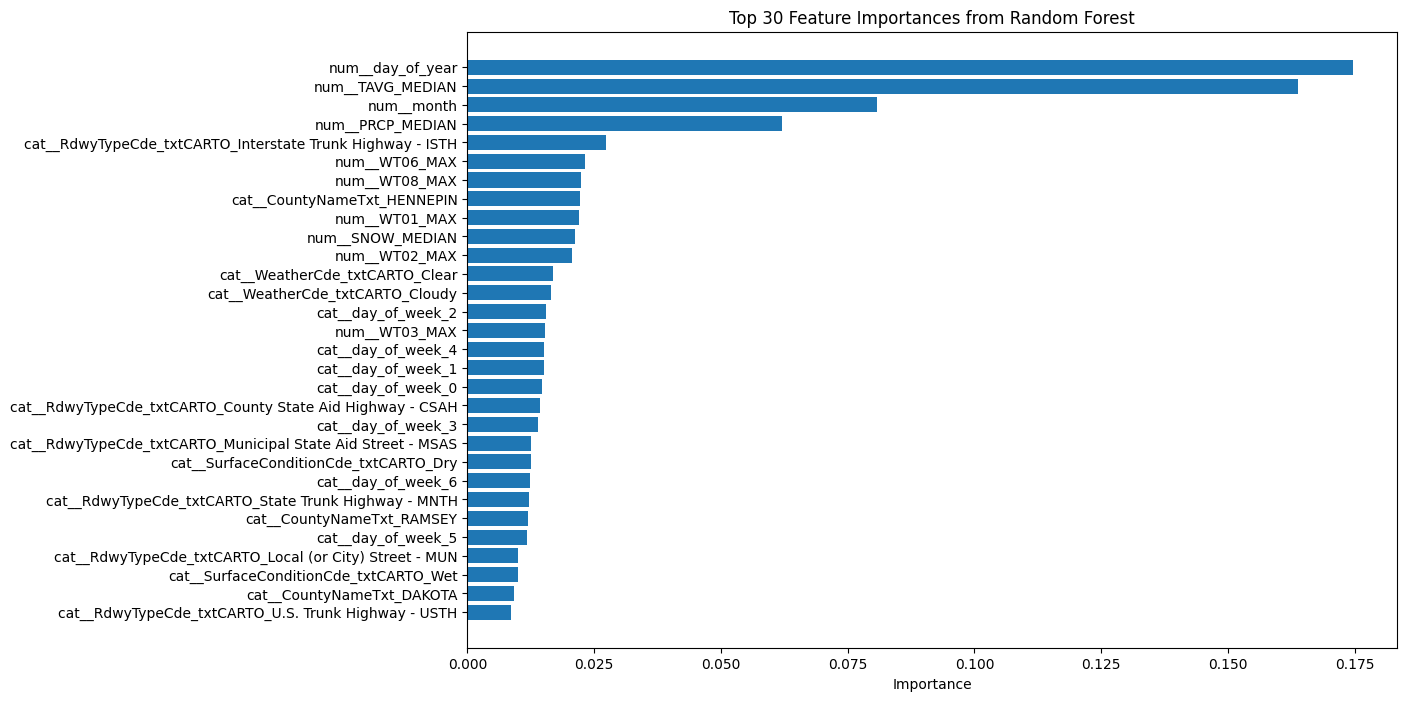

Top 20 Most Important Features:
                                                  Feature  Importance
                                         num__day_of_year    0.174668
                                         num__TAVG_MEDIAN    0.163812
                                               num__month    0.080738
                                         num__PRCP_MEDIAN    0.062128
cat__RdwyTypeCde_txtCARTO_Interstate Trunk Highway - ISTH    0.027303
                                            num__WT06_MAX    0.023279
                                            num__WT08_MAX    0.022475
                              cat__CountyNameTxt_HENNEPIN    0.022170
                                            num__WT01_MAX    0.021926
                                         num__SNOW_MEDIAN    0.021181
                                            num__WT02_MAX    0.020729
                           cat__WeatherCde_txtCARTO_Clear    0.016850
                          cat__WeatherCde_txtCARTO_Cloudy 

In [30]:
# Get feature importances
importances = forest.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 30 most important features
plt.figure(figsize=(12, 8))
plt.title('Top 30 Feature Importances from Random Forest')
plt.barh(importance_df['Feature'].head(30), importance_df['Importance'].head(30))
plt.gca().invert_yaxis() # Display features from most to least important
plt.xlabel('Importance')
plt.show()

print("Top 20 Most Important Features:") 
print(importance_df.sort_values('Importance', ascending=False).head(20).to_string(index=False))
